In [1]:
import numpy as np
import gradflow.comp_graph as cg
import gradflow.dataloader as dl
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
mnist_trn = dl.MNISTLoader("../datasets/MNIST", batch_size=512, split='train')
mnist_trn.load_into_memory()
mnist_trn.shuffle()

# mnist_tst = dl.MNISTLoader("./datasets/MNIST", batch_size=512, split='test')
# mnist_tst.load_into_memory()

In [3]:
X_plt, Y_plt = mnist_trn.get_next_batch()

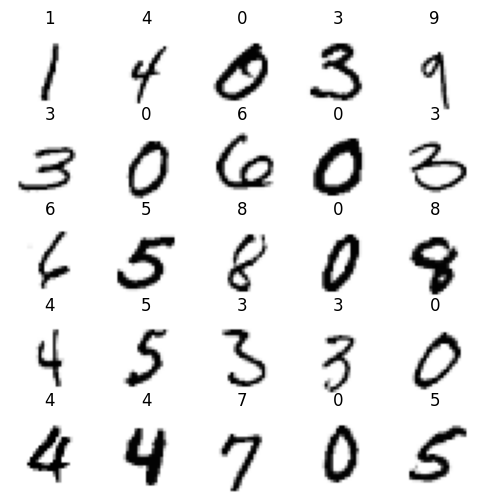

In [4]:
fig, axes = plt.subplots(5, 5, figsize=(6, 6))
axes = axes.flatten()
i = 0
for x, y in zip(X_plt[:25], Y_plt[:25]):
    ax = axes[i]
    ax.imshow(x, cmap='Grays')
    ax.set_axis_off()
    ax.set_title(y)
    i += 1
plt.show()

In [5]:
def transform_img_to_np(imgs):
    X = np.array( [np.array(img, dtype=float).flatten() for img in imgs] )
    X /= 255.
    return X

In [6]:
# define our NN

d_in = 28*28
d_hid = 20
n_classes = 10

w_A_np = np.random.normal(size=(d_in, d_hid))
w_C_np = np.random.normal(size=(d_hid, n_classes))

w_A = cg.Value("w_A", w_A_np, optimize=True) # params in linear layer
linear1 = cg.Dot("linear1")
act1 = cg.ReLU("act1")
w_C = cg.Value("w_C", w_C_np, optimize=True) # params in a linear layer
linear2 = cg.Dot("linear2")
loss = cg.CrossEntropyLoss("crossent", n_classes=n_classes)

def NN_forward(X, Y):
    # calls to forward pass to define the function topology
    X.forward()
    w_A.forward()
    w_C.forward()
    y = linear1.forward(X, w_A)
    y = act1.forward(linear1)
    y = linear2.forward(act1, w_C)
    l = loss.forward(linear2, Y)
    return l

lr = 1e-2
epochs = 100
losses = []
prog_bar = tqdm(range(epochs))
n_batch = mnist_trn.n_batch
for epoch in prog_bar:
    for batch in range(n_batch):
        X_lst, Y_lst = mnist_trn.get_next_batch()
        X_np = transform_img_to_np(X_lst)
        Y_np = np.array(Y_lst)
        X = cg.Value("X", X_np) # input vector

        # call forward pass
        l = NN_forward(X, Y_np)

        losses.append(l.item())

        # call backward pass on topo sorted graph
        fn_graph = cg.Graph("NN", [loss])
        fn_graph.backward()

        # step the optimizer to update weights
        fn_graph.step_optimizer(lr=lr)

    prog_bar.set_description(f"loss: {np.mean(losses[-n_batch:])}")
    

loss: 1.8011722317562688: 100%|██████████| 100/100 [05:09<00:00,  3.10s/it]


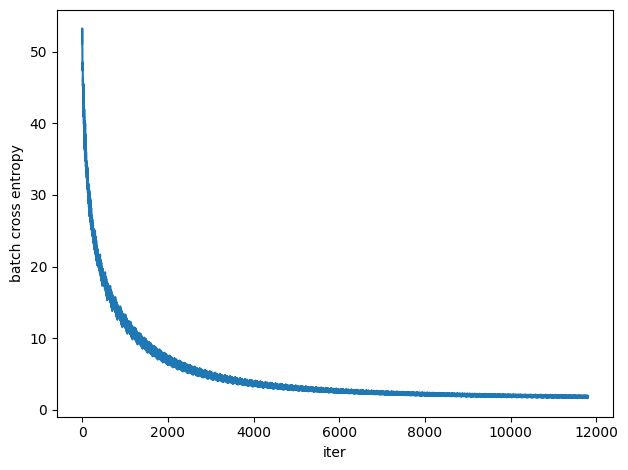

In [8]:
plt.plot(losses)
plt.xlabel("iter")
plt.ylabel("batch cross entropy")
plt.tight_layout()
plt.show()